<a href="https://colab.research.google.com/github/williamlidberg/Geographical-Intelligence/blob/main/Geographical_Intelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository which contains both geospatial data and field data

In [1]:
!git clone https://github.com/williamlidberg/Geographical-Intelligence.git

Cloning into 'Geographical-Intelligence'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 96 (delta 33), reused 71 (delta 33), pack-reused 23
Unpacking objects: 100% (96/96), done.
Checking out files: 100% (56/56), done.


The repository include a multiband raster with topographical data and field data collected by Johannes Larsson. Lets start by having a look at the field data

## Field data

In [2]:
import pandas as pd
chemdata = pd.read_csv('/content/Geographical-Intelligence/data/Krycklan_Chemdata.csv', sep=';')
chemdata

,SampleDepth,cN,cC,C.N.ratio,North,East
0,0,0.28,6.61,23.6,7130777.346,730178.642
1,0,0.49,12.21,24.9,7133579.844,729133.506
2,0,1.11,41.52,37.4,7132175.543,734386.939
3,0,0.67,49.38,73.7,7133576.358,728776.144
4,0,0.69,20.34,29.5,7131481.073,735429.704
...,...,...,...,...,...,...
1493,65,0.02,0.44,22.0,7129032.622,735083.226
1494,65,0.01,0.25,25.0,7128680.029,734376.634
1495,65,0.01,0.28,28.0,7128329.887,734717.649
1496,65,0.01,0.19,19.0,7127982.483,734033.410


In [3]:
import pandas as pd
soildata = pd.read_csv('/content/Geographical-Intelligence/data/Krycklan_Soilsurvey_data.csv', sep=';')
soildata

,SMC,Humusform,HumusformCode,OTh_plot,OTh_pit,SoilType,North,East
0,Mesic,Mor (type 1),1,8.1,8.0,Podzol,7135685.023,732282.698
1,Mesic,Mor (type 1),1,4.1,3.7,Podzol,7135682.996,732633.623
2,Mesic,Mor (type 2),2,11.0,17.0,Podzol,7135328.897,732635.371
3,Mesic,Mor (type 1),1,4.5,7.7,Arenosol,7131479.747,731230.743
4,Mesic,Mor (type 1),1,7.8,7.7,Arenosol,7131138.837,731234.468
...,...,...,...,...,...,...,...,...
436,Mesic,Mor (type 1),1,5.0,6.7,Podzol,7132886.207,736127.745
437,Mesic,Mor (type 1),1,7.1,3.7,Podzol,7133230.314,735431.616
438,Moist,Mor (type 1),1,32.8,22.0,Regosol,7133233.194,735083.716
439,Mesic,Mor (type 1),1,6.3,7.7,Podzol,7133577.628,735431.417


In this demo we will use the soil moisture class from the soildata (SMC). Soil moisture was classified into five classes in the field. We will start by inspecting the data.

In [4]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


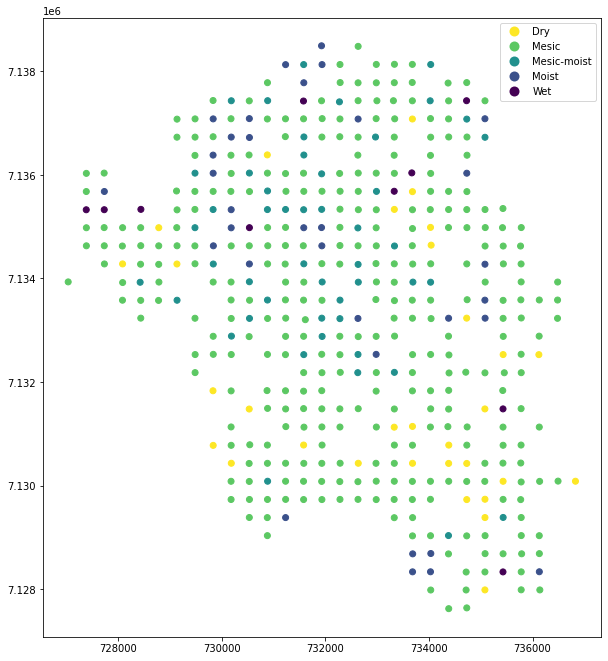

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,20)

gdf = gpd.GeoDataFrame(soildata, geometry=gpd.points_from_xy(soildata.East, soildata.North), crs=3006) # The coordinates are in SWEREFF 99 TM = 3006
gdf.plot(column='SMC', cmap='viridis_r', legend=True)

In [6]:
gdf.to_file('/content/Geographical-Intelligence/data/soildata.shp')  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


Investiagte the distribution of our soil moisture classes in Krycklan

In [53]:
# plot baxplot of SMC

## Rasterdata

 Let's see if we can train a machine learning model to map soil moisture in Krycklan.


Bands and corresponding numbers

1.   DownslopeIndex_2m
2.   DownslopeIndex_4m
3.   DepthToWater_1ha
4.   DepthToWater_2ha
5.   DepthToWater_4ha
6.   DepthToWater_8ha
7.   DepthToWater_16ha
8.   DepthToWater_32ha
9.   ElevationAboveStream_1ha
10.  ElevationAboveStream_2ha
11.  ElevationAboveStream_4ha
12.  ElevationAboveStream_8ha
13.  ElevationAboveStream_16ha
14.  ElevationAboveStream_32ha
15.  PennocLandformClassification
16.  PlanCurvature
17.  RelativeTopographicPosition
18.  TopographicWetnessIndex
19.  WILT
20.  DEM
21.  Slope
22.  DInfFlowaccumulation








In [16]:
import gdal
krycklanstack = gdal.Open('/content/Geographical-Intelligence/data/Rasterstack16m.tif')


Convert each band into a numpy array

In [17]:
import numpy as np

list_of_all_bands = []

for i in range (1, krycklanstack.RasterCount+1):
    band = krycklanstack.GetRasterBand(i)
    list_of_all_bands.append(band.ReadAsArray())

all_data = np.array(list_of_all_bands)

Check the shape of the final numpy array with .shape
The first number is the number of bands, the second number is the Y extent nad the third number is the X extent




In [18]:
all_data.shape

(22, 738, 662)

## Extract values to field plots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [12]:
import rasterio
import geopandas as gpd

# Read points from shapefile
soilplots = gpd.read_file('/content/Geographical-Intelligence/data/soildata.shp')
soilplots.index = range(len(soilplots))
coords = [(x,y) for x, y in zip(soilplots.geometry.x, soilplots.geometry.y)]

# Open the raster and Sample the raster at every point location and store values in DataFrame
src = rasterio.open('/content/Geographical-Intelligence/data/rasters/dem/16m.tif')
soilplots['dem'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/Slope/16m.tif')
soilplots['Slope'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/PlanCurvature/16m.tif')
soilplots['PlanCurvature'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/RelativeTopographicPosition/16m.tif')
soilplots['RelativeTopographicPosition'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/PennockLandFormClass/16m.tif')
soilplots['PennockLandFormClass'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/TopographicWetnessIndex/16m.tif')
soilplots['TopographicWetnessIndex'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/WILT/16m.tif')
soilplots['WILT'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/DownslopeIndex_2m/16m.tif')
soilplots['DownslopeIndex_2m'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/DownslopeIndex_4m/16m.tif')
soilplots['DownslopeIndex_4m'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/DepthToWater_1ha/16m.tif')
soilplots['DepthToWater_1ha'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/DepthToWater_2ha/16m.tif')
soilplots['DepthToWater_2ha'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/DepthToWater_4ha/16m.tif')
soilplots['DepthToWater_4ha'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/DepthToWater_8ha/16m.tif')
soilplots['DepthToWater_8ha'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/DepthToWater_16ha/16m.tif')
soilplots['DepthToWater_16ha'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/DepthToWater_32ha/16m.tif')
soilplots['DepthToWater_32ha'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/ElevationAboveStream_1ha/16m.tif')
soilplots['ElevationAboveStream_1ha'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/ElevationAboveStream_2ha/16m.tif')
soilplots['ElevationAboveStream_2ha'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/ElevationAboveStream_4ha/16m.tif')
soilplots['ElevationAboveStream_4ha'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/ElevationAboveStream_8ha/16m.tif')
soilplots['ElevationAboveStream_8ha'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/ElevationAboveStream_16ha/16m.tif')
soilplots['ElevationAboveStream_16ha'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order

src = rasterio.open('/content/Geographical-Intelligence/data/rasters/ElevationAboveStream_32ha/16m.tif')
soilplots['ElevationAboveStream_32ha'] = [x[0] for x in src.sample(coords)] # Naming is important to keep things in order



In [13]:
soilplots

,SMC,Humusform,HumusformC,OTh_plot,OTh_pit,SoilType,North,East,geometry,dem,...,DepthToWater_4ha,DepthToWater_8ha,DepthToWater_16ha,DepthToWater_32ha,ElevationAboveStream_1ha,ElevationAboveStream_2ha,ElevationAboveStream_4ha,ElevationAboveStream_8ha,ElevationAboveStream_16ha,ElevationAboveStream_32ha
0,Mesic,Mor (type 1),1,8.1,8.0,Podzol,7135685.023,732282.698,POINT (732282.698 7135685.023),254.521194,...,3.899153,3.899153,3.899153,3.908919,1.796549,1.796549,1.796549,1.796549,1.796549,1.796549
1,Mesic,Mor (type 1),1,4.1,3.7,Podzol,7135682.996,732633.623,POINT (732633.623 7135682.996),261.902863,...,10.507881,10.507881,19.977209,19.977209,11.517003,11.517003,11.517003,11.517003,20.164978,20.164978
2,Mesic,Mor (type 2),2,11.0,17.0,Podzol,7135328.897,732635.371,POINT (732635.371 7135328.897),256.292542,...,2.551199,14.654672,14.654672,14.654672,0.000000,0.000000,14.680115,14.680115,14.680115,14.680115
3,Mesic,Mor (type 1),1,4.5,7.7,Arenosol,7131479.747,731230.743,POINT (731230.743 7131479.747),180.441422,...,2.085300,2.666251,4.697031,4.697031,1.075211,1.914719,2.052719,12.334778,12.334778,12.334778
4,Mesic,Mor (type 1),1,7.8,7.7,Arenosol,7131138.837,731234.468,POINT (731234.468 7131138.837),180.148834,...,2.246233,2.543863,4.551040,5.716272,0.161184,1.894623,2.521912,2.617859,4.458348,4.803348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,Mesic,Mor (type 1),1,5.0,6.7,Podzol,7132886.207,736127.745,POINT (736127.745 7132886.207),295.466187,...,17.737881,17.737881,17.737881,23.983110,16.643250,17.114563,17.386209,17.386209,17.386209,22.536102
437,Mesic,Mor (type 1),1,7.1,3.7,Podzol,7133230.314,735431.616,POINT (735431.616 7133230.314),249.213730,...,13.779049,26.108850,26.108850,26.108850,19.462662,19.462662,43.474274,43.474274,47.085327,56.290939
438,Moist,Mor (type 1),1,32.8,22.0,Regosol,7133233.194,735083.716,POINT (735083.716 7133233.194),236.743088,...,3.221983,16.456299,16.456299,16.456299,0.592728,0.592728,3.733246,26.826767,28.599655,54.472229
439,Mesic,Mor (type 1),1,6.3,7.7,Podzol,7133577.628,735431.417,POINT (735431.417 7133577.628),256.152008,...,8.662443,8.662443,8.662443,8.662443,9.078613,9.940872,13.429459,46.235687,48.008575,73.881149


## Train a basic machine learning model
In this case we will use random forest since it is a robust model that preformes well on most data with minimal tuning. 

In [ ]:
soilplots

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder 
#import trainingdata
os.chdir('data')
df_train = pd.read_csv('TrainingData.txt', sep = '\t', decimal = ',')

#slice x training and y predicting variables
var_columns = [c for c in df_train.columns if c not in ['Process', 'Proesskod', 'soil']]
x = df_train.loc[:,var_columns]
y = df_train.loc[:,'Proesskod']

#encode y label to start from 0 xgboost requirement 
le = LabelEncoder()
y_new = le.fit_transform(y)

#split data into 70% training and 30% testing 
x_train, x_test, y_train, y_test = train_test_split(x, y_new, test_size = 0.3, random_state=42, stratify = y)

# Number of trees in random forestssh 
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1500, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

#define random forest model
model_random = RandomForestClassifier()

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model_random, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)
print(rf_random.best_params_)

In [ ]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import sys
import xgboost as xgb
from osgeo import gdal_array
from osgeo import osr
import rasterio as rio  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

#open a raster tile
#ds = gdal.Open('data/SGU/orginal_fran_wl/CompositeBands/14.tif')

#loop over all tiles
allfiles = glob.glob('data/SGU/*.tif')

for tile in allfiles:
    tile_title=tile.split("/")[-1]

    ds = gdal.Open(tile)
    print('bands =', ds.RasterCount)

# 

#########################READ RASTER INTO NUMPY ARRAY###########################
#read each band into a numpy array, drop x, y and soil 
    bands_list=[]
    for i in range (1, ds.RasterCount+1):
        if i in [10, 15, 16]:
            continue
        band = ds.GetRasterBand(i)
        bands_list.append(band.ReadAsArray())

    all_data = np.array(bands_list)
#reshaping numpy array into a table with 16 columns and 1250*1250 rows (size of the raster tiles)
    all_data=all_data.reshape(14,1250*1250).T
    print(all_data.shape)

#make np array dataframe
    df_data=pd.DataFrame(all_data,columns=["DEM","EAS1ha","EAS10ha","DI2m",
    "CVA", "SDFS", "DFME", "Rugged","NMD","HKDepth","SoilDepth","LandAge",
    "MSRM","MED"])
#prediction data has to have the same column order as in the model
    cols=['CVA', 'SDFS', 'Rugged', 'DFME', 'MSRM', 'MED', 'EAS1ha', 'EAS10ha', 'DEM', 'DI2m', 'LandAge', 'SoilDepth', 'HKDepth', 'NMD']
    df_data=df_data[cols]
    print(df_data.head(20))
#print(all_data[0])

#dmatrix format for xgoost model
    all_data_d = xgb.DMatrix(df_data) 
    print('dataframe turned into dmatrix!')
#pd.DataFrame(all_data).to_csv("data/SGU/rasterdata.csv")
#print('finished saving csv!')



##########################XGBOOST MODEL######################
#import trainingdata
    df_train = pd.read_csv('data/SGU/orginal_fran_wl/TrainingData/TrainingData.txt', sep = '\t', decimal = ',')
#slice x training and y predicting variables
    var_columns = [c for c in df_train.columns if c not in ['Process', 'Proesskod','soil', 'POINT_X', 'POINT_Y']]
    x = df_train.loc[:,var_columns]
    y = df_train.loc[:,'Proesskod']

#encode y label to start from 0 xgboost requirement 
    le = LabelEncoder()
    y_new = le.fit_transform(y)

#split data into 70% training and 30% testing 
    x_train, x_test, y_train, y_test = train_test_split(x, y_new, test_size = 0.3, random_state=42, stratify = y)
#make DMatrix for training and test
    train = xgb.DMatrix(x_train, label=y_train)
    test = xgb.DMatrix(x_test, label=y_test)
#set parameters for xgboost model
    param = {'learning_rate': 0.3, 'max_depth' : 12, 'objective':'multi:softmax', 'subsample':0.5, 'n_estimators':1000, 'lambda': 5,
                             'num_class': 7, 'verbosity':1, 'colsample_bytree':0.5, 'min_child_weight':1}
    epochs = 10
#training 
    model = xgb.train(param, train, epochs)
#prediction on raster tile
    pred = model.predict(all_data_d)
    print(len(pred))
    print('prediction made!')
###############################SAVE DATA BACK TO RASTER##########################
#reshape numpy array into 1250x1250
    pred = pred.reshape(1250,1250)
    print(pred)

####save numpy back to raster
    with rio.open(tile) as src:
        ras_data = src.read()
        ras_meta = src.profile
        ras_meta.update(count=1)


    with rio.open('data/'+'output_'+tile_title, 'w', **ras_meta) as dst:
        dst.write(pred, 1)
        print('tile {:s} , raster saved!'.format(tile_title))





In [22]:
!pip install whitebox
import whitebox
#from whitebox import WhiteboxTools
wbt = whitebox.WhiteboxTools()
#wbt = WhiteboxTools()

wbt.extract_raster_values_at_points(
    inputs = '/content/Geographical-Intelligence/data/Rasterstack16m.tif', 
    points = '/content/Geographical-Intelligence/data/soildata.shp', 
    out_text=False
)



./whitebox_tools --run="ExtractRasterValuesAtPoints" --inputs='/content/Geographical-Intelligence/data/Rasterstack16m.tif' --points='/content/Geographical-Intelligence/data/soildata.shp'

******************************************
* Welcome to ExtractRasterValuesAtPoints *
* Powered by WhiteboxTools               *
* www.whiteboxgeo.com                    *
******************************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 1.471s
./whitebox_tools --run="ImageStackProfile" --inputs='/content/Geographical-Intelligence/data/Rasterstack16m.tif' --points='/content/Geographical-Intelligence/data/soildata.shp' --output='/content/Geographical-Intelligence/data/output.html'

********************************
* Welcome to ImageStackProfile *
* Powered by WhiteboxTools     *
* www.whiteboxgeo.com          *
********************************
thread 'main' panicked at 'There is something incorrect about the input files. At least two inputs are 

0